In [1]:
!pip install yfinance
!pip install torchsummaryX
!pip install wandb -q

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 891 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 6.1 MB/s 
     |████████████████████████████████| 182 kB 60.3 MB/s 
     |████████████████████████████████| 168 kB 51.3 MB/s 
     |████████████████████████████████| 62 kB 1.3 MB/s 
     |████████████████████████████████| 140 kB 59.5 MB/s 


In [2]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
import time
import os
import yfinance as yf
import pandas as pd
import datetime
import torch
import torch.nn as nn
from torchsummaryX import summary
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import gc

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.getcwd()

Mounted at /content/drive


'/content'

In [4]:
import wandb
wandb.login(key="03916b709446813b51f72a1b29a2854a9dd9e3f7")

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [22]:
# Training Config
config = {
    "batch_size" : 32,
    "lr" : 1e-3,
    "epochs" : 100,
    "look_back" : 126,
    "feature_dim" : 6,
    "hidden_dim" : 64,
    "output_dim" : 1,
    "num_layers" : 3,
    "dropout" : 0.2
}

In [23]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 200)

class VolatiltiyData:

    def __init__(self, tickers, start_year, start_month, start_date, end_year,
                 end_month, end_date, freq, scaling_factor, windows, y_window):
        self.tickers = tickers
        self.start = datetime.datetime(start_year, start_month, start_date)
        self.end = datetime.datetime(end_year, end_month, end_date)
        self.freq = freq
        self.scaling_factor = scaling_factor
        # 过去几天的vol
        self.windows = windows
        # Predict几天的vol
        self.y_window = y_window 

    def get_data(self):
        """
        Output:
        raw data -> ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 
                     'Log Adj Close', 'Log Return', 'Log Volume', 'Log Volume Chg', 'Log Range', '10-day-vol']
        """
        data = yf.download(self.tickers, start = self.start, end = self.end, interval = self.freq)
        data["Log Adj Close"] = np.log(data["Adj Close"])
        data["Log Return"] = np.insert(np.diff(data["Log Adj Close"]), 0, 0) * self.scaling_factor
        data["Log Volume"] = np.log(data["Volume"])
        data["Log Volume Chg"] = np.insert(np.diff(data["Log Volume"]), 0, 0)
        data["Log Range"] = np.log(data["High"] / data["Low"]) * self.scaling_factor
        data["10-day-vol"] = data["Log Return"].rolling(10).std(ddof=0)
        data["30-day-vol"] = data["Log Return"].rolling(30).std(ddof=0)

        return data

    def get_vix_data(self):
        """
        Output:
        raw vix data -> ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
        """
        data = yf.download("^VIX", start = self.start, end = self.end, interval = self.freq)
        
        return data

    def prepare_data(self, *args):
        """
        Prepare data for training. Select features that are needed. Perform necessary normalization.
        
        For volatiltiy data, we need to remove initial n days since we need at least n days to calculate volatiltiy.

        Input:
        Multiple types of data:
        Basic data: 10-day-vol, Log Volume Chg, Log Range
        Optional data: VIX?

        Output:
        dataset ->  (samples, features)
        scalar  ->  scalar for our normalization

        Current features:
        [10-day-vol, Log Return, Log Volume Chg, Log Range, 30-day-vol, VIX]
        Update based on correlation [10-day-vol, Log Range, 30-day-vol, VIX]
        """
        data = args[0]
        vol_10 = data['10-day-vol'].values.reshape(-1, 1)
        log_return = data['Log Return'].values.reshape(-1, 1)
        log_vlmchg = data['Log Volume Chg'].values.reshape(-1, 1)
        log_range = data['Log Range'].values.reshape(-1, 1)
        vol_30 = data['30-day-vol'].values.reshape(-1, 1)
        
        dataset = vol_10
        dataset = np.append(dataset, log_return, axis=1)
        dataset = np.append(dataset, log_vlmchg, axis = 1)
        dataset = np.append(dataset, log_range, axis = 1)
        dataset = np.append(dataset, vol_30, axis = 1)
        
        # For appending more types of data -> VIX
        for i in range(1, len(args)):
            extra_data = args[i]['Adj Close'].values.reshape(-1, 1)
            dataset = np.append(dataset, extra_data, axis = 1)

        dataset = dataset[31:]
        
        # normalize the dataset
        scaler = MinMaxScaler(feature_range=(0, 1))
        dataset = scaler.fit_transform(dataset)
        return dataset, vol_10, scaler

volatiltiy_data = VolatiltiyData(
                      "^GSPC",
                      1990, 1, 2,
                      2022, 12, 12,
                      freq="1d",
                      scaling_factor=100,
                      windows=[10], # 过去几天的vol
                      y_window=10 # Predict几天的vol
                  )

data = volatiltiy_data.get_data()
# print(np.shape(data))
# print(data)
# print("#######################################################################")
vix_data = volatiltiy_data.get_vix_data()
# print(np.shape(vix_data))
# print(vix_data)
# print("#######################################################################")
dataset, vol_10, scaler = volatiltiy_data.prepare_data(data, vix_data)
print(np.shape(dataset))
# print(dataset)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(8270, 6)


In [24]:
df = data.copy()

df['VIX'] = vix_data['Adj Close']
df['Y'] = list(df['10-day-vol'])[1:] + [0]
df.iloc[31:, :].corr()

,Open,High,Low,Close,Adj Close,Volume,Log Adj Close,Log Return,Log Volume,Log Volume Chg,Log Range,10-day-vol,30-day-vol,VIX,Y
Open,1.000000,0.999939,0.999908,0.999841,0.999841,0.606128,0.928038,-0.007309,0.662764,-0.000161,-0.030450,0.025482,0.039784,0.005281,0.025495
High,0.999939,1.000000,0.999878,0.999916,0.999916,0.607602,0.928124,-0.000608,0.663549,0.000218,-0.025355,0.030240,0.043871,0.008986,0.030176
Low,0.999908,0.999878,1.000000,0.999924,0.999924,0.603854,0.928091,0.001205,0.661675,-0.001773,-0.038569,0.020281,0.035356,-0.000993,0.020006
Close,0.999841,0.999916,0.999924,1.000000,1.000000,0.605676,0.928174,0.007725,0.662611,-0.001164,-0.032200,0.025501,0.039853,0.003284,0.025198
Adj Close,0.999841,0.999916,0.999924,1.000000,1.000000,0.605676,0.928174,0.007725,0.662611,-0.001164,-0.032200,0.025501,0.039853,0.003284,0.025198
Volume,0.606128,0.607602,0.603854,0.605676,0.605676,1.000000,0.676620,-0.025952,0.909445,0.107652,0.287947,0.334698,0.339552,0.312287,0.339322
Log Adj Close,0.928038,0.928124,0.928091,0.928174,0.928174,0.676620,1.000000,0.006101,0.823790,-0.001052,0.007233,0.063723,0.080503,0.022871,0.063375
Log Return,-0.007309,-0.000608,0.001205,0.007725,0.007725,-0.025952,0.006101,1.000000,-0.012735,-0.028871,-0.104016,-0.005016,-0.001999,-0.134462,-0.028897
Log Volume,0.662764,0.663549,0.661675,0.662611,0.662611,0.909445,0.823790,-0.012735,1.000000,0.084669,0.196749,0.240805,0.255808,0.200707,0.242190
Log Volume Chg,-0.000161,0.000218,-0.001773,-0.001164,-0.001164,0.107652,-0.001052,-0.028871,0.084669,1.000000,0.160535,-0.009776,-0.008562,0.009929,-0.009615


In [25]:
class DataLoaderForVolatilityModeling(DataLoader):
    """
    Construct dataloader
  
    The label for our data is the next 10-day volatility after our input.

    Output:
    input -> (batch_size, seq_len, feature_size)
    label -> (batch_size, 1, feature_size) 
    """
    def __init__(self, dataset, vol_10, batch_size, sequence_length, shuffle=True, feature_size=1):
        self.dataset = dataset
        self.vol_10 = vol_10
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.sequence_length = sequence_length
        self.num_batches = (np.shape(self.dataset)[0]-10) // self.batch_size
        self.feature_size = feature_size

    def __len__(self):
        return self.num_batches - self.sequence_length

    def __iter__(self):
        # group the sequence into batches
        x = torch.from_numpy(np.reshape(self.dataset[:self.num_batches*self.batch_size, :], (self.batch_size, self.num_batches, config['feature_dim']))).type(torch.float32)
        y = torch.from_numpy(np.reshape(self.vol_10[10:self.num_batches*self.batch_size+10, :], (self.batch_size, -1))).type(torch.float32)

        # return a tuple of (input, label) on every iteration with yield
        index = 0
        while index+self.sequence_length < self.num_batches:
            time_steps = self.sequence_length
            input = x[:, index:index+time_steps, :]
            label = y[:, index+time_steps].view(self.batch_size, 1)
            index += 1
            yield input, label

In [26]:
# sanity check
dataloader = DataLoaderForVolatilityModeling(dataset, vol_10, batch_size=config["batch_size"], sequence_length=config["look_back"], feature_size=config["feature_dim"])
tmp = iter(dataloader)
input, label = next(tmp) 
print(f'input shape = {np.shape(input)}')
print(f'label shape = {np.shape(label)}')

input shape = torch.Size([32, 126, 6])
label shape = torch.Size([32, 1])


In [27]:
# model
class Model(nn.Module):
    """
    Construct model architecture
    """
    def __init__(self, feature_dim, hidden_dim, output_dim):
        super(Model, self).__init__()
        self.lstm = torch.nn.GRU(input_size=feature_dim, hidden_size=hidden_dim, num_layers=config["num_layers"], 
                                  dropout=config["dropout"], batch_first=True, bias=True, bidirectional=True)
        self.relu = torch.nn.ReLU()
        self.linear = torch.nn.Linear(in_features=hidden_dim*2, out_features=output_dim, bias=True)

    def forward(self, x):
        x, h = self.lstm(x)
        x = x[:, -1, :]
        x = self.relu(x)
        x = self.linear(x)
        return x

In [28]:
# sanity check
torch.cuda.empty_cache()

model = Model(config['feature_dim'], config['hidden_dim'], config['output_dim']).to(device)
prediction = model(input.to(device))
print(f'shape of prediction : {prediction.shape}')
print(f'shape of label : {label.shape}')

summary(model, input.to(device))

shape of prediction : torch.Size([32, 1])
shape of label : torch.Size([32, 1])
         Kernel Shape    Output Shape   Params Mult-Adds
Layer                                                   
0_lstm              -  [32, 126, 128]  176.64k  174.336k
1_relu              -       [32, 128]        -         -
2_linear     [128, 1]         [32, 1]    129.0     128.0
----------------------------------------------------------
                        Totals
Total params          176.769k
Trainable params      176.769k
Non-trainable params       0.0
Mult-Adds             174.464k


/usr/local/lib/python3.8/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_lstm,-,"[32, 126, 128]",176640.0,174336.0
1_relu,-,"[32, 128]",NaN,NaN
2_linear,"[128, 1]","[32, 1]",129.0,128.0


In [29]:
# Prepare loader
train_size = int(len(dataset) * 0.5)
val_size = int(len(dataset) * 0.2)
test_size = len(dataset) - train_size - val_size
train_data, val_data, test_data = dataset[0:train_size,:], dataset[train_size:train_size+val_size,:], dataset[train_size+val_size:len(dataset),:]
train_vol_10, val_vol_10, test_vol_10 = vol_10[0:train_size,:], vol_10[train_size:train_size+val_size,:], vol_10[train_size+val_size:len(dataset),:]

train_loader = DataLoaderForVolatilityModeling(train_data, train_vol_10, batch_size=config['batch_size'], sequence_length=config['look_back'], shuffle=True)
val_loader = DataLoaderForVolatilityModeling(val_data, val_vol_10, batch_size=10, sequence_length=config['look_back'], shuffle=False)
test_loader = DataLoaderForVolatilityModeling(test_data, test_vol_10, batch_size=1, sequence_length=config['look_back'], shuffle=False)

# Prepare optimizer, criterion, and scheduler_lr
optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'], weight_decay = 5e-5) # What goes in here?
criterion = torch.nn.MSELoss()
scheduler_lr = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.75, patience=2, verbose=True)

In [30]:
# Evaluate
def evaluate(val_loader, model, criterion):
    model.eval()

    batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, position=0, leave=False, desc="Val")

    val_loss = 0

    for i, (input, target) in enumerate(val_loader):

        input, target = input.to(device), target.to(device)

        with torch.inference_mode():
            prediction = model(input)

        loss = criterion(prediction.flatten(), target.flatten())

        val_loss += loss.item()
        # print(loss.item())

        batch_bar.set_postfix(
            loss = f"{val_loss/ (i+1):.4f}",
            lr = f"{curr_lr}"
        )

        batch_bar.update()

        torch.cuda.empty_cache()
        del input
        del target

    batch_bar.close()
    val_loss /= len(dataloader)

    return val_loss

In [31]:
# Train Step
def train_step(train_loader, model, optimizer, criterion):
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
    train_loss = 0
    model.train()

    for i, (input, target) in enumerate(train_loader):
        input, target = input.to(device), target.to(device)
        curr_lr = optimizer.param_groups[0]['lr']

        optimizer.zero_grad()
        prediction = model(input)
        # print(f'prediction : {prediction}')
        # print(f'target : {target}')
        loss = criterion(prediction.flatten(), target.flatten())
        # print(f'loss : {loss.item()}')

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        batch_bar.set_postfix(
            loss = f"{train_loss/ (i+1):.4f}",
            lr = f"{curr_lr}"
        )

        batch_bar.update()

        torch.cuda.empty_cache()
        del input
        del target
    
    batch_bar.close()
    train_loss /= len(train_loader)
    
    return train_loss

In [32]:
# Initialize wandb
run = wandb.init(
    name = "LSTM_mult_feats_6", ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "10701_Volatility_Prediction", ### Project should be created in your wandb account 
    config = config ### Wandb Config for your run
)

In [33]:
best_val_loss = 100

# Train loop
torch.cuda.empty_cache()
gc.collect()

train_loss, val_loss = 0, 0

for epoch in range(config["epochs"]):
    
    curr_lr = optimizer.param_groups[0]['lr']

    train_loss = train_step(train_loader, model, optimizer, criterion)

    val_loss = evaluate(val_loader, model, criterion)

    scheduler_lr.step(train_loss)

    print("\nEpoch {}/{}: \n\t Train Loss {:.07f}\t Eval Loss {:.07f}\t Learning Rate {:.04f}\t".format(
          epoch + 1,
          config['epochs'],
          train_loss,
          val_loss,
          curr_lr))
    
    wandb.log({"train_loss":train_loss, 'val_loss': val_loss, "learning_Rate": curr_lr})

    if val_loss < best_val_loss:
        path = '/content/drive/MyDrive/10701/checkpoint/checkpoint_eval_loss_haha'.format(val_loss)
        torch.save({'model_state_dict': model.state_dict()}, path)
        best_val_loss = val_loss

wandb.save(path)
run.finish()


Epoch 1/100: 
	 Train Loss 0.7373580	 Eval Loss 0.5444427	 Learning Rate 0.0010	



Epoch 2/100: 
	 Train Loss 0.5380730	 Eval Loss 0.4658038	 Learning Rate 0.0010	



Epoch 3/100: 
	 Train Loss 0.3758771	 Eval Loss 0.3879178	 Learning Rate 0.0010	



Epoch 4/100: 
	 Train Loss 0.2367725	 Eval Loss 0.3165438	 Learning Rate 0.0010	



Epoch 5/100: 
	 Train Loss 0.1589143	 Eval Loss 0.2677086	 Learning Rate 0.0010	



Epoch 6/100: 
	 Train Loss 0.1758653	 Eval Loss 0.2559394	 Learning Rate 0.0010	



Epoch 7/100: 
	 Train Loss 0.2055205	 Eval Loss 0.2572878	 Learning Rate 0.0010	


Epoch 00008: reducing learning rate of group 0 to 7.5000e-04.

Epoch 8/100: 
	 Train Loss 0.1871150	 Eval Loss 0.2668559	 Learning Rate 0.0010	



Epoch 9/100: 
	 Train Loss 0.1592079	 Eval Loss 0.2791597	 Learning Rate 0.0008	



Epoch 10/100: 
	 Train Loss 0.1475678	 Eval Loss 0.2920893	 Learning Rate 0.0008	



Epoch 11/100: 
	 Train Loss 0.1490023	 Eval Loss 0.3006184	 Learning Rate 0.0008	



Epoch 12/100: 
	 Train Loss 0.1538343	 Eval Loss 0.3028834	 Learning Rate 0.0008	


Epoch 00013: reducing learning rate of group 0 to 5.6250e-04.

Epoch 13/100: 
	 Train Loss 0.1559409	 Eval Loss 0.2989725	 Learning Rate 0.0008	



Epoch 14/100: 
	 Train Loss 0.1502537	 Eval Loss 0.2931296	 Learning Rate 0.0006	



Epoch 15/100: 
	 Train Loss 0.1496637	 Eval Loss 0.2860628	 Learning Rate 0.0006	



Epoch 16/100: 
	 Train Loss 0.1437987	 Eval Loss 0.2791467	 Learning Rate 0.0006	



Epoch 17/100: 
	 Train Loss 0.1435436	 Eval Loss 0.2733680	 Learning Rate 0.0006	



Epoch 18/100: 
	 Train Loss 0.1454875	 Eval Loss 0.2691669	 Learning Rate 0.0006	



Epoch 19/100: 
	 Train Loss 0.1418315	 Eval Loss 0.2666525	 Learning Rate 0.0006	



Epoch 20/100: 
	 Train Loss 0.1408834	 Eval Loss 0.2657791	 Learning Rate 0.0006	



Epoch 21/100: 
	 Train Loss 0.1401253	 Eval Loss 0.2664099	 Learning Rate 0.0006	



Epoch 22/100: 
	 Train Loss 0.1352108	 Eval Loss 0.2679428	 Learning Rate 0.0006	



Epoch 23/100: 
	 Train Loss 0.1368032	 Eval Loss 0.2695111	 Learning Rate 0.0006	



Epoch 24/100: 
	 Train Loss 0.1380240	 Eval Loss 0.2706074	 Learning Rate 0.0006	



Epoch 25/100: 
	 Train Loss 0.1322386	 Eval Loss 0.2704950	 Learning Rate 0.0006	



Epoch 26/100: 
	 Train Loss 0.1290412	 Eval Loss 0.2686114	 Learning Rate 0.0006	



Epoch 27/100: 
	 Train Loss 0.1323039	 Eval Loss 0.2653063	 Learning Rate 0.0006	



Epoch 28/100: 
	 Train Loss 0.1269866	 Eval Loss 0.2607425	 Learning Rate 0.0006	



Epoch 29/100: 
	 Train Loss 0.1244789	 Eval Loss 0.2556596	 Learning Rate 0.0006	



Epoch 30/100: 
	 Train Loss 0.1287372	 Eval Loss 0.2509479	 Learning Rate 0.0006	



Epoch 31/100: 
	 Train Loss 0.1236523	 Eval Loss 0.2468264	 Learning Rate 0.0006	



Epoch 32/100: 
	 Train Loss 0.1189024	 Eval Loss 0.2437610	 Learning Rate 0.0006	



Epoch 33/100: 
	 Train Loss 0.1171982	 Eval Loss 0.2409270	 Learning Rate 0.0006	



Epoch 34/100: 
	 Train Loss 0.1117505	 Eval Loss 0.2380891	 Learning Rate 0.0006	



Epoch 35/100: 
	 Train Loss 0.1101459	 Eval Loss 0.2342807	 Learning Rate 0.0006	



Epoch 36/100: 
	 Train Loss 0.1047955	 Eval Loss 0.2284894	 Learning Rate 0.0006	



Epoch 37/100: 
	 Train Loss 0.1039276	 Eval Loss 0.2205149	 Learning Rate 0.0006	



Epoch 38/100: 
	 Train Loss 0.0991298	 Eval Loss 0.2110191	 Learning Rate 0.0006	



Epoch 39/100: 
	 Train Loss 0.0930972	 Eval Loss 0.2018934	 Learning Rate 0.0006	



Epoch 40/100: 
	 Train Loss 0.0817358	 Eval Loss 0.1936356	 Learning Rate 0.0006	



Epoch 41/100: 
	 Train Loss 0.0776523	 Eval Loss 0.1851021	 Learning Rate 0.0006	



Epoch 42/100: 
	 Train Loss 0.0719559	 Eval Loss 0.1746825	 Learning Rate 0.0006	



Epoch 43/100: 
	 Train Loss 0.0701076	 Eval Loss 0.1641778	 Learning Rate 0.0006	



Epoch 44/100: 
	 Train Loss 0.0582870	 Eval Loss 0.1564258	 Learning Rate 0.0006	



Epoch 45/100: 
	 Train Loss 0.0595728	 Eval Loss 0.1519070	 Learning Rate 0.0006	



Epoch 46/100: 
	 Train Loss 0.0600012	 Eval Loss 0.1492833	 Learning Rate 0.0006	


Epoch 00047: reducing learning rate of group 0 to 4.2188e-04.

Epoch 47/100: 
	 Train Loss 0.0614148	 Eval Loss 0.1507101	 Learning Rate 0.0006	



Epoch 48/100: 
	 Train Loss 0.0582670	 Eval Loss 0.1532443	 Learning Rate 0.0004	



Epoch 49/100: 
	 Train Loss 0.0552681	 Eval Loss 0.1568711	 Learning Rate 0.0004	



Epoch 50/100: 
	 Train Loss 0.0542229	 Eval Loss 0.1614172	 Learning Rate 0.0004	



Epoch 51/100: 
	 Train Loss 0.0536644	 Eval Loss 0.1654326	 Learning Rate 0.0004	



Epoch 52/100: 
	 Train Loss 0.0490896	 Eval Loss 0.1691759	 Learning Rate 0.0004	



Epoch 53/100: 
	 Train Loss 0.0485879	 Eval Loss 0.1728184	 Learning Rate 0.0004	



Epoch 54/100: 
	 Train Loss 0.0488617	 Eval Loss 0.1742060	 Learning Rate 0.0004	



Epoch 55/100: 
	 Train Loss 0.0461375	 Eval Loss 0.1749544	 Learning Rate 0.0004	



Epoch 56/100: 
	 Train Loss 0.0491433	 Eval Loss 0.1752089	 Learning Rate 0.0004	



Epoch 57/100: 
	 Train Loss 0.0476671	 Eval Loss 0.1747851	 Learning Rate 0.0004	


Epoch 00058: reducing learning rate of group 0 to 3.1641e-04.

Epoch 58/100: 
	 Train Loss 0.0486372	 Eval Loss 0.1743322	 Learning Rate 0.0004	



Epoch 59/100: 
	 Train Loss 0.0465250	 Eval Loss 0.1741789	 Learning Rate 0.0003	



Epoch 60/100: 
	 Train Loss 0.0478243	 Eval Loss 0.1741407	 Learning Rate 0.0003	



Epoch 61/100: 
	 Train Loss 0.0454784	 Eval Loss 0.1741570	 Learning Rate 0.0003	



Epoch 62/100: 
	 Train Loss 0.0460864	 Eval Loss 0.1742438	 Learning Rate 0.0003	



Epoch 63/100: 
	 Train Loss 0.0480711	 Eval Loss 0.1745746	 Learning Rate 0.0003	



Epoch 64/100: 
	 Train Loss 0.0440956	 Eval Loss 0.1744511	 Learning Rate 0.0003	



Epoch 65/100: 
	 Train Loss 0.0430571	 Eval Loss 0.1742274	 Learning Rate 0.0003	



Epoch 66/100: 
	 Train Loss 0.0458772	 Eval Loss 0.1743400	 Learning Rate 0.0003	



Epoch 67/100: 
	 Train Loss 0.0433094	 Eval Loss 0.1744904	 Learning Rate 0.0003	



Epoch 68/100: 
	 Train Loss 0.0427765	 Eval Loss 0.1747484	 Learning Rate 0.0003	



Epoch 69/100: 
	 Train Loss 0.0487055	 Eval Loss 0.1750404	 Learning Rate 0.0003	



Epoch 70/100: 
	 Train Loss 0.0430012	 Eval Loss 0.1754153	 Learning Rate 0.0003	


Epoch 00071: reducing learning rate of group 0 to 2.3730e-04.

Epoch 71/100: 
	 Train Loss 0.0441325	 Eval Loss 0.1754785	 Learning Rate 0.0003	



Epoch 72/100: 
	 Train Loss 0.0456668	 Eval Loss 0.1757724	 Learning Rate 0.0002	



Epoch 73/100: 
	 Train Loss 0.0456948	 Eval Loss 0.1760941	 Learning Rate 0.0002	


Epoch 00074: reducing learning rate of group 0 to 1.7798e-04.

Epoch 74/100: 
	 Train Loss 0.0430906	 Eval Loss 0.1763870	 Learning Rate 0.0002	



Epoch 75/100: 
	 Train Loss 0.0431656	 Eval Loss 0.1764913	 Learning Rate 0.0002	



Epoch 76/100: 
	 Train Loss 0.0445312	 Eval Loss 0.1765370	 Learning Rate 0.0002	


Epoch 00077: reducing learning rate of group 0 to 1.3348e-04.

Epoch 77/100: 
	 Train Loss 0.0452039	 Eval Loss 0.1765883	 Learning Rate 0.0002	



Epoch 78/100: 
	 Train Loss 0.0430016	 Eval Loss 0.1766338	 Learning Rate 0.0001	



Epoch 79/100: 
	 Train Loss 0.0425356	 Eval Loss 0.1766821	 Learning Rate 0.0001	



Epoch 80/100: 
	 Train Loss 0.0422193	 Eval Loss 0.1767610	 Learning Rate 0.0001	



Epoch 81/100: 
	 Train Loss 0.0430548	 Eval Loss 0.1768273	 Learning Rate 0.0001	



Epoch 82/100: 
	 Train Loss 0.0433736	 Eval Loss 0.1768313	 Learning Rate 0.0001	


Epoch 00083: reducing learning rate of group 0 to 1.0011e-04.

Epoch 83/100: 
	 Train Loss 0.0428858	 Eval Loss 0.1769220	 Learning Rate 0.0001	



Epoch 84/100: 
	 Train Loss 0.0438362	 Eval Loss 0.1769695	 Learning Rate 0.0001	



Epoch 85/100: 
	 Train Loss 0.0414249	 Eval Loss 0.1770266	 Learning Rate 0.0001	



Epoch 86/100: 
	 Train Loss 0.0436890	 Eval Loss 0.1770999	 Learning Rate 0.0001	



Epoch 87/100: 
	 Train Loss 0.0422549	 Eval Loss 0.1772190	 Learning Rate 0.0001	


Epoch 00088: reducing learning rate of group 0 to 7.5085e-05.

Epoch 88/100: 
	 Train Loss 0.0423599	 Eval Loss 0.1774075	 Learning Rate 0.0001	



Epoch 89/100: 
	 Train Loss 0.0427903	 Eval Loss 0.1775525	 Learning Rate 0.0001	



Epoch 90/100: 
	 Train Loss 0.0417161	 Eval Loss 0.1776743	 Learning Rate 0.0001	



Epoch 91/100: 
	 Train Loss 0.0411190	 Eval Loss 0.1778424	 Learning Rate 0.0001	



Epoch 92/100: 
	 Train Loss 0.0423843	 Eval Loss 0.1779959	 Learning Rate 0.0001	



Epoch 93/100: 
	 Train Loss 0.0415366	 Eval Loss 0.1780919	 Learning Rate 0.0001	


Epoch 00094: reducing learning rate of group 0 to 5.6314e-05.

Epoch 94/100: 
	 Train Loss 0.0426092	 Eval Loss 0.1781667	 Learning Rate 0.0001	



Epoch 95/100: 
	 Train Loss 0.0406300	 Eval Loss 0.1782060	 Learning Rate 0.0001	



Epoch 96/100: 
	 Train Loss 0.0411660	 Eval Loss 0.1782407	 Learning Rate 0.0001	



Epoch 97/100: 
	 Train Loss 0.0416771	 Eval Loss 0.1783034	 Learning Rate 0.0001	


Epoch 00098: reducing learning rate of group 0 to 4.2235e-05.

Epoch 98/100: 
	 Train Loss 0.0416075	 Eval Loss 0.1783925	 Learning Rate 0.0001	



Epoch 99/100: 
	 Train Loss 0.0406225	 Eval Loss 0.1784371	 Learning Rate 0.0000	


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")



Epoch 100/100: 
	 Train Loss 0.0403309	 Eval Loss 0.1784789	 Learning Rate 0.0000	


learning_Rate,████▆▆▅▅▅▅▅▅▅▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
train_loss,█▄▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▃▄▄▃▃▃▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂
learning_Rate,4e-05
train_loss,0.04033
val_loss,0.17848


In [34]:
# checkpoint = torch.load(path)
# model.load_state_dict(checkpoint['model_state_dict'])

In [35]:
# Prediction
def predict(test_loader, model):
    model.eval()
    preds, targets = [], []
    test_loss = 0

    for i, (input, target) in enumerate(test_loader):

        input, target = input.to(device), target.to(device)

        with torch.inference_mode():
            prediction = model(input)

        test_loss += criterion(prediction.flatten(), target.flatten())

        # Note: Each loaded data is a column
        prediction = prediction.cpu().detach().numpy() # (batch_size, feature_size)
        target = target.cpu().detach().numpy() # (batch_size, feature_size)

        preds.append(prediction.flatten()[0])
        targets.append(target.flatten()[0])

        del input
        del target
    
    test_loss /= len(test_loader)

    return preds, targets, test_loss

In [36]:
torch.cuda.empty_cache()
gc.collect()

preds, targets, test_loss = predict(test_loader, model)

loss = 'Eval loss : {:.07}'.format(best_val_loss)
print(loss)

loss = 'Test loss : {:.07}'.format(test_loss)
print(loss)

Eval loss : 0.1492833
Test loss : 0.2605872


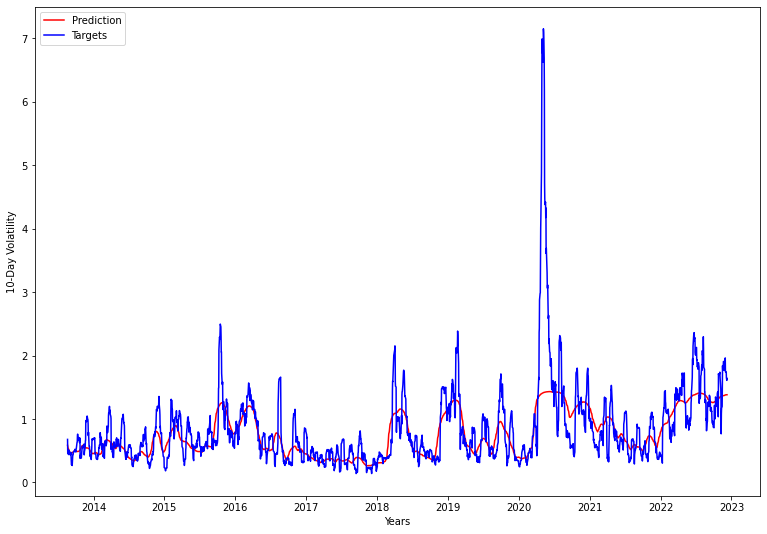

In [37]:
df = data.copy()
df = df.tail(len(preds))
df.drop(df.columns, inplace=True, axis=1)
df['preds'] = preds

# Generate output
plt.figure(figsize=(13,9))
plt.plot(df.index, preds, label="Prediction", color="red")
plt.plot(df.index, targets, label="Targets", color="blue")
plt.xlabel("Years")
plt.ylabel("10-Day Volatility")
plt.legend(loc="upper left")
plt.show()

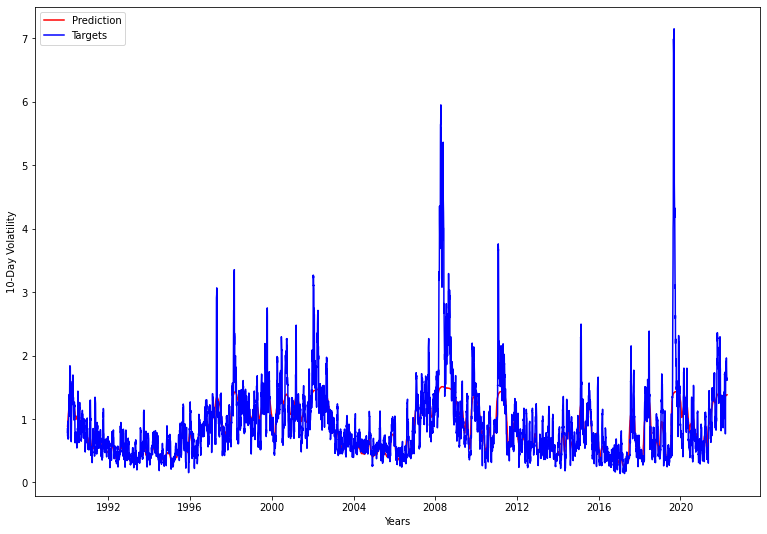

Test loss : 0.2106754


In [38]:
# Prediction for the entire dataset
data_loader = DataLoaderForVolatilityModeling(dataset, vol_10,batch_size=1, sequence_length=config['look_back'], shuffle=False)

# Make predictions
preds, targets, test_loss = predict(data_loader, model)

# Generate output
plt.figure(figsize=(13,9))
plt.plot(data.index[:len(preds)], preds, label="Prediction", color="red")
plt.plot(data.index[:len(targets)], targets, label="Targets", color="blue")
plt.xlabel("Years")
plt.ylabel("10-Day Volatility")
plt.legend(loc="upper left")
plt.show()

loss = 'Test loss : {:.07}'.format(test_loss)
print(loss)